# Test of algorithms for dimensional reduction

## Basic setup

### Import the library with Ctypes

I wrote the algorithms in a C++ library, which can be called from Python using ctypes

In [23]:
# The following is used to close the library, so it can be loaded again after updating it
handle = lib._handle
del lib
_ctypes.dlclose(handle)

In [1]:
import _ctypes
import ctypes

# Load the library
# The methods below work for me
# lib = ctypes.cdll.LoadLibrary( os.getcwd() + "/../DSAlgorithms/build/libDSAlgorithms.so.1.0.1" )
lib = ctypes.cdll.LoadLibrary( "../DSAlgorithms/build/libDSAlgorithms.so" )

### Import other Python packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set the default size for the plots with matplotlib
matplotlib.rcParams[ "figure.figsize" ] = [ 10, 6 ]
matplotlib.rcParams[ "figure.dpi" ] = 100


## Principal component analysis

#### Wrappers for the functions written in C++

In [3]:
def PCA_in_Cpp(data, dimReduced=2):
    # Array for the output of the computation in C++
    reducedData = np.zeros( (len(data), dimReduced), dtype=np.double )
    # Make sure that both arrays are contiguous, and that their data type is correct
    if not data.flags["C_CONTIGUOUS"]:
        data = np.ascontiguousarray( data )
    if not reducedData.flags["C_CONTIGUOUS"]:
        reducedData = np.ascontiguousarray( reducedData )
    if not data.dtype == 'float':
        data = data.astype( 'float' )
    if not reducedData.dtype == 'float':
        reducedData = reducedData.astype( 'float' )

    # Setup the types of the arguments of the function
    lib.computePCA.argtypes = [ np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ),
                                ctypes.c_int, ctypes.c_int, 
                                np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ),
                                ctypes.c_int ]
    # Setup the type of the return value of the function
    # lib.computePCA.restype = None # Void return type
    lib.computePCA.restype = ctypes.POINTER( ctypes.c_double * len(data[0]) * dimReduced )

    # Call the function
    # lib.computePCA( data, len(data), len(data[0]), reducedData, dimReduced )
    mostSignEigenvectors = lib.computePCA( data, len(data), len(data[0]), reducedData, dimReduced )

    # Converthe most significant eigenvectors to a numpy array
    mostSignEigenvectors = np.array( [ [ i for i in eigen ] for eigen in mostSignEigenvectors.contents ] )

    # Return the result of the function
    return reducedData, mostSignEigenvectors

#### Apply it on the `test_temperature.dat` dataset

In [5]:
# Load the dataset
file = open('Datasets/test_temperature.dat')
data = []

for line in file:
    data.append( [] )
    line_aux = line.split( ' ' )
    for i in range( len(line_aux) ):
        # Remove the first (city name) and last (direction) elements of each line
        # if i != 0 and i < len(line_aux) - 1:
        if i != 0 and i < len(line_aux) - 5:
            data[-1].append( float(line_aux[i]) )
data = np.array( data )
file.close()

In [10]:
# Perform PCA on the data
# reducedData, _ = PCA_in_Cpp(data, 2)
reducedData, mostSignEigenvectors = PCA_in_Cpp(data, 2)

Performing PCA on the dataset...


Below I show some plots to view the data projected in the space of these two most significant variables, which I call $(U_1, U_2)$.

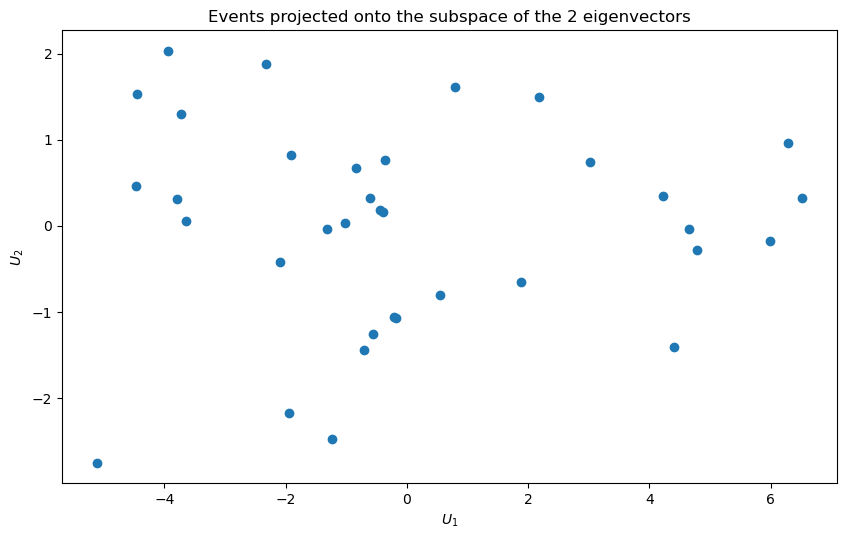

In [11]:
# Plot the results
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title('Events projected onto the subspace of the 2 eigenvectors')
ax1.scatter(reducedData[:, 0], reducedData[:, 1])
ax1.set_xlabel(r'$U_1$')
ax1.set_ylabel(r'$U_2$')

plt.show()

Now I plot the projection of the different original features onto the two most significant eigenvectors.
This is, the components of the vector that would correspond to each feature in the reduced plane $(U_1, U_2)$.

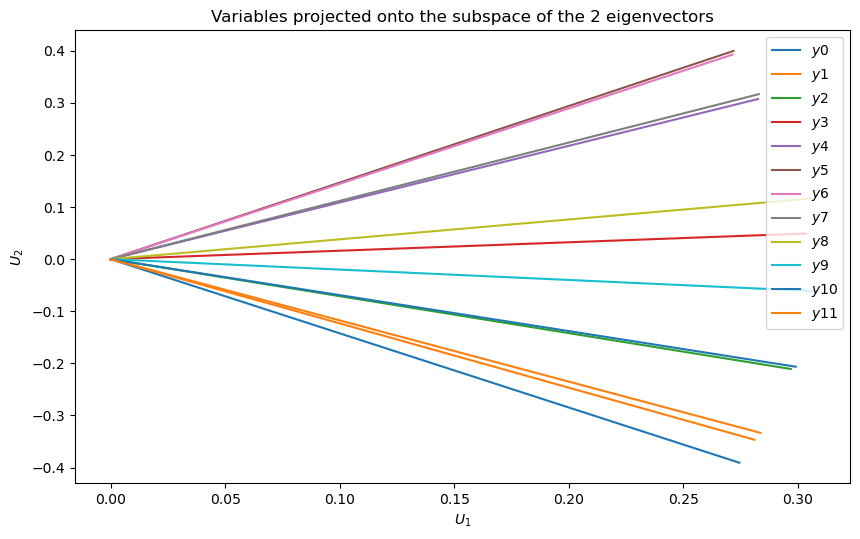

In [12]:
# Plot the projections of the variables in the plane of the two most significant directions

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_title("Variables projected onto the subspace of the 2 eigenvectors")
for i in range( len(data[0]) ):
    ax2.plot( [ 0, mostSignEigenvectors[0][i] ],
              [ 0, mostSignEigenvectors[1][i] ], 
              label='$y{}$'.format(i) )

ax2.set_xlabel(r'$U_1$')
ax2.set_ylabel(r'$U_2$')
ax2.legend( loc="best" )
plt.show()


#### Apply it on the `iris.dat` dataset

In [13]:
# Load the dataset
data = np.loadtxt('Datasets/test_iris.dat')
# Take only the first 4 columns.
data = data[:, :4]

In [14]:
# Perform PCA on the data
# reducedData, _ = PCA_in_Cpp(data, 2)
reducedData, mostSignEigenvectors = PCA_in_Cpp(data, 2)

Performing PCA on the dataset...


Below I plot the data projected in the space of these two most significant variables, which I call $(U_1, U_2)$.

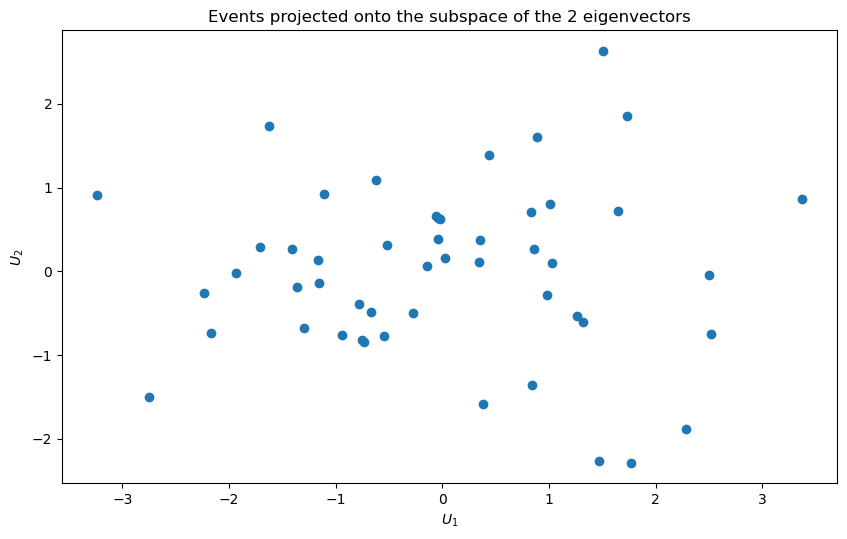

In [15]:
# Plot the results
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title('Events projected onto the subspace of the 2 eigenvectors')
ax1.scatter(reducedData[:, 0], reducedData[:, 1])
ax1.set_xlabel(r'$U_1$')
ax1.set_ylabel(r'$U_2$')

plt.show()

Now I plot the projection of the different original features onto the two most significant eigenvectors.
This is, the components of the vector that would correspond to each feature in the reduced plane $(U_1, U_2)$.

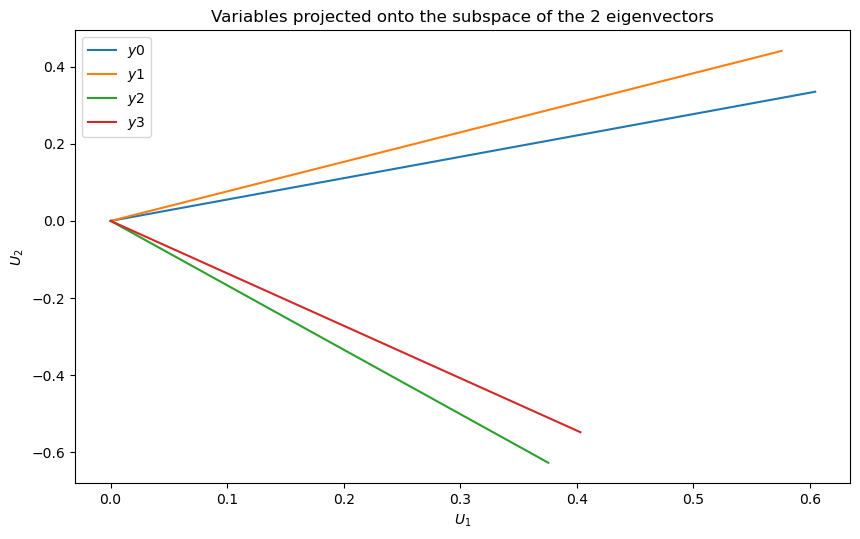

In [16]:
# Plot the projections of the variables in the plane of the two most significant directions

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_title("Variables projected onto the subspace of the 2 eigenvectors")
for i in range( len(data[0]) ):
    ax2.plot( [ 0, mostSignEigenvectors[0][i] ],
              [ 0, mostSignEigenvectors[1][i] ], 
              label='$y{}$'.format(i) )

ax2.set_xlabel(r'$U_1$')
ax2.set_ylabel(r'$U_2$')
ax2.legend( loc="best" )
plt.show()


#### Apply it on the iris dataset (full dataset, from Scikit-learn)

In [18]:
# Import the dataset as a pandas dataframe

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the iris dataset from sklearn
iris = load_iris()
# Convert this to a pandas dataframe
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['class'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [19]:
# Perform PCA on the data
# Notice how I write the argument when calling the function, so it is passed as a numpy array
reducedData, mostSignEigenvectors = PCA_in_Cpp( df.drop(labels='class', axis=1).values, 2)

Performing PCA on the dataset...


Below I plot the data projected in the space of these two most significant variables, which I call $(U_1, U_2)$.

The different colors in the plot correspond to the different classes.

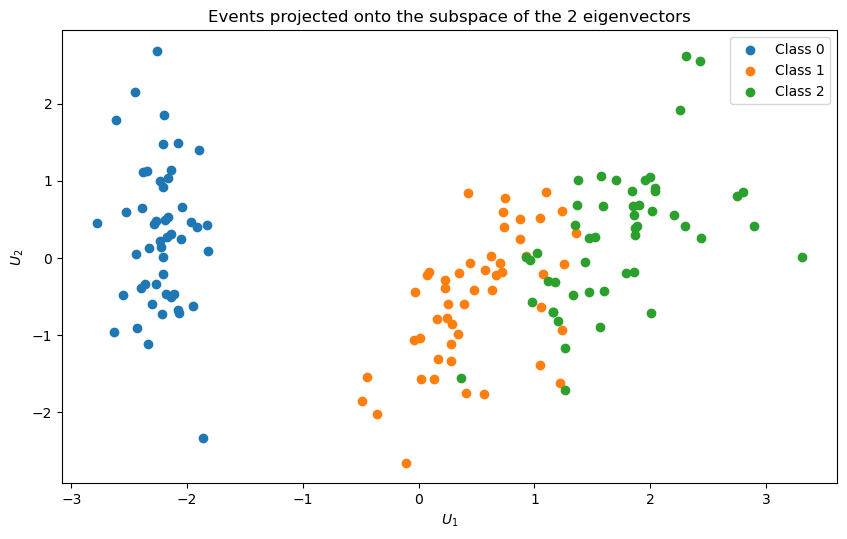

In [20]:
# Plot the results
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title('Events projected onto the subspace of the 2 eigenvectors')

# Plot the points corresponding to each class with a different color
for cl in range( max( df['class'].values ) - min( df['class'].values ) + 1 ):
    mask = df['class'] == cl
    ax1.scatter( reducedData[mask, 0], reducedData[mask, 1], label="Class {}".format(cl) )

# ax1.scatter(reducedData[:, 0], reducedData[:, 1])
ax1.set_xlabel(r'$U_1$')
ax1.set_ylabel(r'$U_2$')
ax1.legend(loc='best')

plt.show()

Now I plot the projection of the different original features onto the two most significant eigenvectors.
This is, the components of the vector that would correspond to each feature in the reduced plane $(U_1, U_2)$.

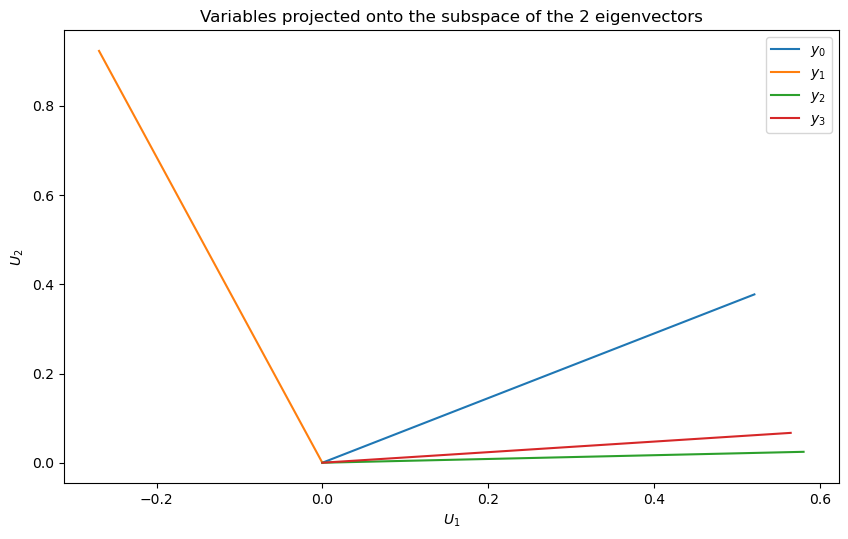

In [21]:
# Plot the projections of the variables in the plane of the two most significant directions

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_title("Variables projected onto the subspace of the 2 eigenvectors")
for i in range( len(data[0]) ):
    ax2.plot( [ 0, mostSignEigenvectors[0][i] ],
              [ 0, mostSignEigenvectors[1][i] ], 
              label='$y_{}$'.format(i) )

ax2.set_xlabel(r'$U_1$')
ax2.set_ylabel(r'$U_2$')
ax2.legend( loc="best" )
plt.show()
